In [1]:
%matplotlib inline

import pymongo
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [3]:
# NOTE - Turn off VPN when running pymongo
client = pymongo.MongoClient(port=27017)
db = client.metrics_causal_model

cb_td, cb_vd, sc_td, sc_vd = "CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_TD", "CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_VD", \
    "CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_TD", "CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_VD"
cb_td, cb_vd, sc_td, sc_vd = db[cb_td], db[cb_vd], db[sc_td], db[sc_vd]
cb_td, cb_vd, sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_VD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_VD'))

# Query Top Features

In [4]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            "stemmed":        "$parameters.stemmed",
            "num_feats":      "$parameters.num_feats_MEAN",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

print(len(cb_td_rows), len(cb_vd_rows), len(sc_td_rows), len(sc_vd_rows))

13 13 13 13


In [5]:
def gbl_feats(fts):
    return [ft for ft in fts if ft.startswith("gbl")]

def hash_feats(fts):
    fts = gbl_feats(fts)
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(3)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,num_feats,stemmed,weighted_f1_score,hs_feats
0,5cb244d5e116f56ce8f83904,2019-04-13 15:21:41.607,8,"[single_words, between_word_features, label_se...",0.743292,0.738473,0.748175,62689.0,True,0.0,gbl_causal_features|gbl_ratio_features
1,5cb24169e116f56ce8f838f8,2019-04-13 15:07:05.813,7,"[single_words, between_word_features, label_se...",0.741360,0.738941,0.743796,62243.6,True,0.0,gbl_causal_features
2,5cb245a2e116f56ce8f83906,2019-04-13 15:25:06.523,8,"[single_words, between_word_features, label_se...",0.741228,0.742313,0.740146,62205.0,True,0.0,gbl_causal_features|gbl_sentence_position_feat...


In [6]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2019-04-13T15:01:37.857000000'),
 numpy.datetime64('2019-04-13T15:38:11.152000000'))

In [7]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision,stemmed,num_feats".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, count, stemmed=True):
    df = df.copy(deep=True)
    df_top_individual_feats = df[(df["count"] == count) & (df["stemmed"] == stemmed)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

get_top_individual_feats(cb_vd_df, 6, True)

,feats,count,micro_f1_score,micro_recall,micro_precision,stemmed,num_feats,rank
9,"single_words,between_word_features,label_set,t...",6,0.735595,0.74781,0.723773,True,59376.4,1


### Performance of Each Feature In Isolation

In [8]:
import numpy as np

cb_seed_feats = "single_words,between_word_features,label_set,three_words,third_order,unigrams,"
sc_seed_feats = "three_words,between_word_features,size_features,single_words,"

cb_seed_count = len([f for f in cb_seed_feats.split(",") if f != ""])
sc_seed_count = len([f for f in sc_seed_feats.split(",") if f != ""])

# For CB, starts with 6 features while SC starts with 4, so set to 7 and 5 as the feature count
a = get_top_individual_feats(cb_vd_df, count=cb_seed_count+1, stemmed=True)
b = get_top_individual_feats(sc_vd_df, count=sc_seed_count+1, stemmed=True)

a["feats"] = a["feats"].apply(lambda s: s.replace(cb_seed_feats,""))
b["feats"] = b["feats"].apply(lambda s: s.replace(sc_seed_feats,""))
a["additional_feats"] = a["count"] - cb_seed_count
b["additional_feats"] = b["count"] - sc_seed_count

merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,num_feats_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats_SC".split(",")]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,num_feats_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats_SC
0,1,gbl_causal_features,0.741360,0.743796,0.738941,62243.6,gbl_concept_code_cnt_features,0.806460,0.797870,0.815237,63152.2
1,2,gbl_concept_code_cnt_features,0.739918,0.753285,0.727017,60576.4,gbl_ratio_features,0.803467,0.799391,0.807584,62237.6
2,3,gbl_adjacent_sent_code_features,0.737941,0.748175,0.727983,60362.8,gbl_sentence_position_features,0.801843,0.794319,0.809512,63091.2
3,4,gbl_sentence_position_features,0.735516,0.745985,0.725337,59014.6,gbl_adjacent_sent_code_features,0.801186,0.787979,0.814844,63376.0
4,5,gbl_ratio_features,0.731872,0.749635,0.714932,58854.8,gbl_causal_features,0.799737,0.771747,0.829834,68150.2


In [9]:
merged2=merged[["rank","feats_CB", "micro_f1_score_CB", "feats_SC", "micro_f1_score_SC"]].copy()
for c in merged2.columns:
    if "micro" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:.3f}".format(d) if type(d) == float else d)
    elif "num" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:,.1f}".format(d) if type(d) == float else d)
merged2

,rank,feats_CB,micro_f1_score_CB,feats_SC,micro_f1_score_SC
0,1,gbl_causal_features,0.741,gbl_concept_code_cnt_features,0.806
1,2,gbl_concept_code_cnt_features,0.740,gbl_ratio_features,0.803
2,3,gbl_adjacent_sent_code_features,0.738,gbl_sentence_position_features,0.802
3,4,gbl_sentence_position_features,0.736,gbl_adjacent_sent_code_features,0.801
4,5,gbl_ratio_features,0.732,gbl_causal_features,0.800


## Generate Rows for LaTex Table

In [10]:
def format_lbl(lbl):
    if lbl.lower().strip() == "nan" or lbl.strip() == "":
        return "-"
    lbl = lbl.replace("gbl_","").replace("["," ").replace("]","").replace("_"," ").strip()
    return " ".join([l[0].upper() + l[1:] for l in lbl.split(" ")])

In [11]:
for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & Causal Features & 0.741 & & Concept Code Cnt Features & 0.806\\
2 & Concept Code Cnt Features & 0.740 & & Ratio Features & 0.803\\
3 & Adjacent Sent Code Features & 0.738 & & Sentence Position Features & 0.802\\
4 & Sentence Position Features & 0.736 & & Adjacent Sent Code Features & 0.801\\
5 & Ratio Features & 0.732 & & Causal Features & 0.800\\


## Performance By Feature Set Size

In [12]:
def get_by_featureset_size(df, seed_count):
    grpd = group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              #("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")
    grpd["count"] = grpd["count"] - seed_count
    return grpd

pd.merge(get_by_featureset_size(cb_vd_df, cb_seed_count), get_by_featureset_size(sc_vd_df, sc_seed_count), on="count", how="outer", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,max(micro_f1_score)_sc
0,0,0.735595,0.804630
1,1,0.741360,0.806460
2,2,0.743292,0.806674
3,3,0.740255,0.804291


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [13]:
#cols_filter = "count,new_feat,micro_f1_score,micro_recall,micro_precision,window_size".split(",")
cols_filter = "count,new_feat,micro_f1_score,stemmed,num_feats".split(",")

def get_f1_by_feat_count(df):
    df=df.sort_values("micro_f1_score", ascending=False).copy(deep=True)
    df["feats"] = df["feats"].apply(gbl_feats)
    df["count"] = df["feats"].apply(len)
    df=df[df["stemmed"] == True]
    top_feats = df[df["count"] == df["count"].max()]
    top_feats = top_feats.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]
    top_feats = [""] + top_feats
    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)

        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
##df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

#get_f1_by_feat_count(cb_vd_df)
#get_f1_by_feat_count(sc_vd_df)

df_f1_score_by_feat_size

,count,new_feat_CB,micro_f1_score_CB,stemmed_CB,num_feats_CB,new_feat_SC,micro_f1_score_SC,stemmed_SC,num_feats_SC
0,0,,0.735595,True,59376.4,,0.804630,True,63053.0
1,1,gbl_causal_features,0.741360,True,62243.6,gbl_concept_code_cnt_features,0.806460,True,63152.2
2,2,gbl_ratio_features,0.743292,True,62689.0,gbl_causal_features,0.806674,True,68242.6
3,3,gbl_adjacent_sent_code_features,0.740255,True,64059.8,gbl_sentence_position_features,0.804291,True,68532.2


In [14]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,num_feats_CB,micro_f1_score_CB,new_feat_SC,num_feats_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))
df["num_feats_CB"]      = df["num_feats_CB"].apply(lambda d: "{0:,.1f}".format(d))
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
df["num_feats_SC"]      = df["num_feats_SC"].apply(lambda d: "{0:,.1f}".format(d))
df

,count,new_feat_CB,num_feats_CB,micro_f1_score_CB,new_feat_SC,num_feats_SC,micro_f1_score_SC
0,0,,"59,376.4",0.7356,,"63,053.0",0.8046
1,1,gbl_causal_features,"62,243.6",0.7414,gbl_concept_code_cnt_features,"63,152.2",0.8065
2,2,gbl_ratio_features,"62,689.0",0.7433,gbl_causal_features,"68,242.6",0.8067
3,3,gbl_adjacent_sent_code_features,"64,059.8",0.7403,gbl_sentence_position_features,"68,532.2",0.8043


# Plot F1 Score Against # Feature Sets

### Get the Max F1 Score for Each Size of Feature Set (Win = 9)

In [15]:
def get_max_f1_by_feat_count(df):
    df=df.copy(deep=True)
    df["feats"] = df["feats"].apply(gbl_feats)
    df["count"] = df["feats"].apply(len)
    max_feats = df["count"].values.max()
    rows = []
    for cnt in range(0, max_feats+1):
        
        row = df[df["count"] == cnt].sort_values("micro_f1_score", ascending=False).iloc[0]        
        rows.append(row)

    return pd.DataFrame(rows)

In [16]:
df_cb = get_max_f1_by_feat_count(cb_vd_df[cb_vd_df["stemmed"] == True])[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
df_sc = get_max_f1_by_feat_count(sc_vd_df[sc_vd_df["stemmed"] == True])[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
by_feat_size = pd.merge(df_cb, df_sc, on="count", how="outer", suffixes=["_CB", "_SC"])
by_feat_size

,count,feats_CB,micro_f1_score_CB,micro_precision_CB,micro_recall_CB,feats_SC,micro_f1_score_SC,micro_precision_SC,micro_recall_SC
0,0,[],0.735595,0.723773,0.747810,[],0.804630,0.816284,0.793305
1,1,[gbl_causal_features],0.741360,0.738941,0.743796,[gbl_concept_code_cnt_features],0.806460,0.815237,0.797870
2,2,"[gbl_causal_features, gbl_ratio_features]",0.743292,0.738473,0.748175,"[gbl_concept_code_cnt_features, gbl_causal_fea...",0.806674,0.829936,0.784682
3,3,"[gbl_causal_features, gbl_ratio_features, gbl_...",0.740255,0.738909,0.741606,"[gbl_concept_code_cnt_features, gbl_causal_fea...",0.804291,0.830586,0.779609


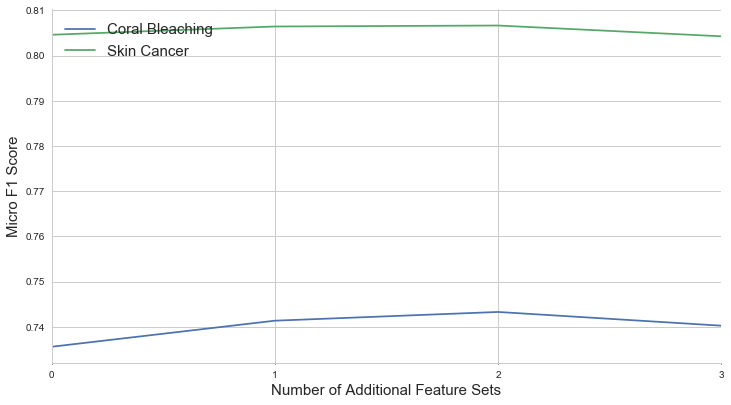

In [131]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 3])
# ax1.set_ylim([0.695, 0.77])
ax1.set_xlabel('Number of Additional Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/sr_causal_model_parser_f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

### F1 Score As Individual Features are Added

In [18]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

0 & - & 0.7356 & & - & 0.8046\\
1 & Causal Features & 0.7414 & & Concept Code Cnt Features & 0.8065\\
2 & Ratio Features & 0.7433 & & Causal Features & 0.8067\\
3 & Adjacent Sent Code Features & 0.7403 & & Sentence Position Features & 0.8043\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [19]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats","stemmed"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"

### Estimate Reduction in Features

#### Coral Bleaching

In [39]:
df[df["count"] == 6]

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,num_feats,stemmed,weighted_f1_score,hs_feats
9,5cb24021e116f56ce8f838f4,2019-04-13 15:01:37.857,6,"[single_words, between_word_features, label_se...",0.735595,0.723773,0.74781,59376.4,True,0.0,


In [113]:
df = cb_vd_df

In [114]:
init_count = df[df["count"] == df["count"].min()]["num_feats"].values[0]
init_count

59376.4

In [124]:
inc_counts = df[df["count"] == (df["count"].min()+1)][["hs_feats","num_feats", "micro_f1_score"]]
inc_counts["addnl_cnt"] = inc_counts["num_feats"] - init_count
inc_counts["pct_change"] = 100.0*(inc_counts["addnl_cnt"]/init_count)
inc_counts

,hs_feats,num_feats,micro_f1_score,addnl_cnt,pct_change
1,gbl_causal_features,62243.6,0.741360,2867.2,4.828855
4,gbl_concept_code_cnt_features,60576.4,0.739918,1200.0,2.021005
8,gbl_adjacent_sent_code_features,60362.8,0.737941,986.4,1.661266
10,gbl_sentence_position_features,59014.6,0.735516,-361.8,-0.609333
12,gbl_ratio_features,58854.8,0.731872,-521.6,-0.878463


In [109]:
sub = df[df["count"] == 8][["count","hs_feats","num_feats", "micro_f1_score"]]
sub["addnl_feats"] = sub["num_feats"] - baseline_cb_feats
sub.sort_values("micro_f1_score", ascending=False)

,count,hs_feats,num_feats,micro_f1_score,addnl_feats
0,8,gbl_causal_features|gbl_ratio_features,62689.0,0.743292,3312.6
2,8,gbl_causal_features|gbl_sentence_position_feat...,62205.0,0.741228,2828.6
5,8,gbl_adjacent_sent_code_features|gbl_causal_fea...,64730.0,0.739273,5353.6
6,8,gbl_causal_features|gbl_concept_code_cnt_features,63237.2,0.738989,3860.8


In [110]:
sub.sort_values("micro_f1_score", ascending=False).iloc[0]
best_count = sub.sort_values("micro_f1_score", ascending=False).iloc[0]["num_feats"]
best_count

62689.0

In [83]:
# see /Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/CoralBleachingCausalModel/count_all_feats.py
max_feats = 64935.4
best_count / max_feats

0.9654056185070085

In [106]:
best_count / init_count

1.1493219528297438

#### Skin Cancer

In [75]:
# /Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/Experiments/SkinCancerCausalModel/count_all_feats.py

In [128]:
df = sc_vd_df

In [129]:
init_count = df[df["count"] == df["count"].min()]["num_feats"].values[0]
init_count

63053.0

In [130]:
inc_counts = df[df["count"] == (df["count"].min()+1)][["hs_feats","num_feats", "micro_f1_score"]]
inc_counts["addnl_cnt"] = inc_counts["num_feats"] - init_count
inc_counts["pct_change"] = 100.0*(inc_counts["addnl_cnt"]/init_count)
inc_counts

,hs_feats,num_feats,micro_f1_score,addnl_cnt,pct_change
1,gbl_concept_code_cnt_features,63152.2,0.806460,99.2,0.157328
6,gbl_ratio_features,62237.6,0.803467,-815.4,-1.293198
9,gbl_sentence_position_features,63091.2,0.801843,38.2,0.060584
11,gbl_adjacent_sent_code_features,63376.0,0.801186,323.0,0.512267
12,gbl_causal_features,68150.2,0.799737,5097.2,8.083993


In [88]:
df.sort_values("micro_f1_score", ascending=False).iloc[0]

_id                                           5cb24f6ee116f56fac52ac5a
asof                                        2019-04-13 16:06:54.614000
count                                                                6
feats                [three_words, between_word_features, size_feat...
micro_f1_score                                                0.806674
micro_precision                                               0.829936
micro_recall                                                  0.784682
num_feats                                                      68242.6
stemmed                                                           True
weighted_f1_score                                                    0
hs_feats             gbl_causal_features|gbl_concept_code_cnt_features
Name: 0, dtype: object

In [ ]:
# optimal sc feat count = 68242.6

In [90]:
best_count = df.sort_values("micro_f1_score", ascending=False).iloc[0].num_feats
best_count

68242.6

In [91]:
max_feats = 68375.8

In [93]:
best_count / max_feats

0.9980519423538737

In [103]:
init_feats = 63053.0
best_count / init_feats

1.0823053621556469